<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

/bin/bash: line 1: apt-get: command not found


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


**Part 4 - Composing functions** 

Motivated by its use in the calculation of available potential energy (APE) (cf. [Winters et al. JFM. (1995)](https://doi.org/10.1017/S002211209500125X) and [Tseng and Ferziger. Phys. Fluids. (2001)](https://doi.org/10.1063/1.1358307)), in this notebook we explain how the composition of functions is achieved by *NumDF*. The APE of a buoyancy field $B(\mathbf{x})$ of vertical extent $Z(\mathbf{x})$ is given by the difference of its potential energy (PE) and the background or reference potential energy 
\begin{equation}
\mathbb{E}[BZ^*]  - \mathbb{E}[BZ] = \iint b \left(Z^*(b) -z \right) \; f_{BZ}(b,z) \; dbdz,
\end{equation}
where the reference state
\begin{equation}
Z^*(b) = F^{-1}_Z \circ F_B(b) = Q_Z \circ F_B(b),
\end{equation}
corresponds to an adiabatic volume preserving rearrangement of the fluid into a state that minimizes PE. To calculate this quantity therefore requires an estimation of the buoyancy field's PDF and CDF $f_B, F_B$, the vertical coordinate's QDF $Q_Z = F_Z^{-1}$ and an ability to compose these functions. As an example of a buoyancy field and potential we will consider
\begin{align}
    B(x_1,x_2) &= 4x_2(1 - x_2),\\
    Z(x_1,x_2) &= x_2,
\end{align}
such that the physical domain is given by $\Omega_X \in [-1,1] \times [0,1]$, the buoyancy domain $\Omega_B \in [0,1]$ and that of the potential by $\Omega_Z \in [0,1]$. To construct the finite element approximation of the buoyancy's PDF & CDF $\mathsf{f}_B,\mathsf{F}_B$ and the vertical coordinate's QDF $\mathsf{F}_Z^{-1}$ we make use of the **Ptp** class imported below.

In [2]:
from numdf import Ptp
from firedrake import *
from firedrake.__future__ import interpolate

We first set up the domain of the buoyancy $B$

In [3]:
ptp_B = Ptp(Omega_X={'x1': (-1, 1),'x2': (0, 1)}, Omega_Y={'Y': (0, 1)}, n_elements=75)

Using this domain we then compute the CDF and PDF of the buoyancy field, by calling the fit method.

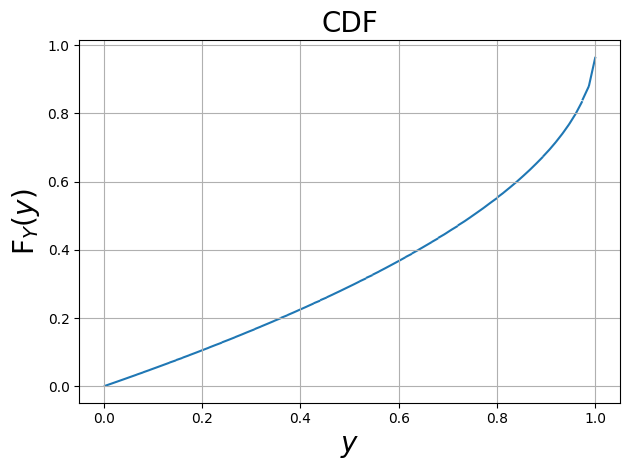

In [4]:
# Construct the PDF,CDF,QDF
x1,x2 = ptp_B.x_coords()
density_B = ptp_B.fit(Y=4*x2*(1 - x2), Range_Y= {'Y_min':0, 'Y_max':1}, quadrature_degree=1000) 
density_B.plot(function='CDF')

To obtain the QDF of the co-ordinate field $Z$ we follow a similar procedure.

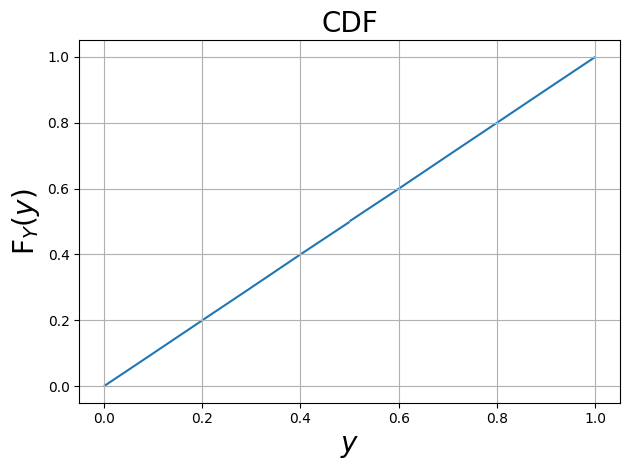

In [5]:
# Set the domain & function space
ptp_Z = Ptp(Omega_X={'x1': (-1, 1),'x2': (0, 1)}, Omega_Y={'Y': (0, 1)}, n_elements=10)

# Construct the PDF,CDF,QDF
x1,x2 = ptp_Z.x_coords()
density_Z = ptp_Z.fit(Y=x2, Range_Y= {'Y_min':0, 'Y_max':1}, quadrature_degree=200)
density_Z.plot(function='CDF')

Having obtained all necessary functions it remains to obtain the reference height $Z^*(b)$ and evaluate the integral to compute the APE. To obtain the reference height we construct a function Z_ref as below using a quadrature element. At the nodes of the quadrature element we shall evaluate the function composition $Z^*(b) = \mathsf{Q}_Z \circ \mathsf{F}_B(b)$.

In [6]:
# Define a function space for Z_ref
quadrature_degree = 250

mesh_F = density_B.cdf.function_space().mesh()
mesh_Q = density_Z.qdf.function_space().mesh()

V_ZE    = FiniteElement(family="Quadrature",cell="interval",degree=quadrature_degree,quad_scheme='default')
V_Z     = FunctionSpace(mesh=mesh_F, family=V_ZE)
Z_ref   = Function(V_Z)

With the quadrature element defined we now grab the quadrature points $b_q$

In [7]:
# First, grab the mesh.
m = V_Z.mesh()

# Now make the VectorFunctionSpace corresponding to V_Z.
W = VectorFunctionSpace(m, V_Z.ufl_element())

# Next, interpolate the coordinates onto the nodes of W.
X = assemble(interpolate(m.coordinates, W))

We now avail of a vertex only mesh in order to compute $\mathsf{F}_q = \mathsf{F}_B(b_q)$, the CDF evaluated at the quadrature points $b_q$. 

In [8]:
b_q = [ [b_i,] for b_i in X.dat.data[:]]
vom = VertexOnlyMesh(mesh_F, b_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
F = assemble(interpolate(density_B.cdf, P0DG))

And using the same methods again we compute $\mathsf{Q}_q = \mathsf{Q}_Z(\mathsf{F}_q)$, QDF evaluated at the points $\mathsf{F}_q = \mathsf{F}_B(b_q)$.

In [9]:
F_q = [ [F_i,] for F_i in F.dat.data[:]]
vom = VertexOnlyMesh(mesh_Q, F_q)

# P0DG is the only function space you can make on a vertex-only mesh
P0DG = FunctionSpace(vom, "DG", 0)

# Interpolation performs point evaluation
# [test_vertex_only_mesh_manual_example 2]
Q_q = assemble(interpolate(density_Z.qdf, P0DG))

We can then parse these values into the dofs of Z_ref

In [10]:
Z_ref.dat.data[:] = Q_q.dat.data[:]

Finally to ensure we can evaluate Z_ref at all points we must project into a function space. Choosing the function space 'DG1' (that of the CDF) and keeping the same quadrature degree for the inner product involving Z_ref as was used when defining this function, we solve for its piecewise discontinuous counterpart Z_star below.

In [11]:
mesh_B = density_B.cdf.function_space().mesh()
V_star = FunctionSpace(mesh=mesh_B, family='DG', degree=1)

u = TrialFunction(V_star)
v = TestFunction(V_star)

a = inner(u,v)*dx
L = inner(Z_ref,v)*dx(degree=quadrature_degree)

Z_star = Function(V_star)
solve(a == L, Z_star)

To evaluate the background potential energy (bpe) we must integrate the expression
\begin{equation*}
\mathbb{E}[BZ^*] = \int b Z^*(b) \; d\mathsf{F}(b),
\end{equation*}
which we can write in terms of its Riesz representation as
\begin{equation*}
\mathbb{E}[BZ^*] = \langle b Z^*(b), \mathsf{f}_0(b) \rangle_{V_{\mathsf{f}_0}} + \langle b Z^*(b), \mathsf{f}_1(b) \rangle_{V_{\mathsf{f}_1}}.
\end{equation*}
While the first part of this integral associated with the cells is well defined and can be evaluated, the second part is only defined when $Z^*(b)$ is continuous across element facets or when a choice for how it should be evaluated at these points is specified. Writing the integral over a single element
\begin{equation*}
    \int_{e} b Z^*(b) \nabla \mathsf{F} db = - \int_{e} \left( \nabla b Z^*(b) \right) \mathsf{F} db + \int_{\partial e} b Z^*(b) \mathsf{F} db
\end{equation*}
and taking the average of the second term across the cell facet we obtain
\begin{equation*}
    \int_{e} b Z^*(b) \nabla \mathsf{F} db = - \int_{e} \left( \nabla b Z^*(b) \right) \mathsf{F} db +  \frac{1}{2} \left[ (b Z^*(b) \mathsf{F})^+ - (b Z^*(b) \mathsf{F})^- \right]|_{b = b_e}.
\end{equation*}
Integrating over all cells it follows that the latter term can be expressed as
\begin{equation*}
    \langle b Z^*(b), \mathsf{f}_1(b) \rangle_{V_{\mathsf{f}_1}} \coloneqq -\sum_e \frac{1}{2} \left[ (b Z^*(b) \mathsf{F})^+ - (b Z^*(b) \mathsf{F})^- \right]|_{b = b_e} = -\sum_e \frac{1}{2} \left[ (b Z^*(b))^+ - (b Z^*(b))^- \right]|_{b = b_e} [[\mathsf{F}]]_e,
\end{equation*}
the average of $bZ^*(b)$ times the jump in the CDF at each facet. Below we use this choice to evaluate the expression
\begin{equation*}
\mathbb{E}[BZ^*] = \langle b Z^*(b), \mathsf{f}_0(b) \rangle_{V_{\mathsf{f}_0}} + \langle b Z^*(b), \mathsf{f}_1(b) \rangle_{V_{\mathsf{f}_1}}.
\end{equation*}
which can be implemented manually as

In [12]:
# Calculate the BPE
b = density_B.y
f0 = density_B.pdf["f0"]
f1 = density_B.pdf["f1"]

#           cell integral                       facet integral
BPE = assemble(b*Z_star*f0*dx) + assemble(avg(b*Z_star)*f1*dS + b*Z_star*f1*ds)

(where $\texttt{dS}, \texttt{ds}$ are the measures associated with the internal and external facets) or automatically in terms of the callable

In [13]:
# Calculate the BPE
b = density_B.y
BPE = density_B(b*Z_star)

To calculate the total potential energy (tpe) we evaluate the integral
\begin{equation}
\mathbb{E}[BZ] = -\frac{1}{V}\int B(X) Z(X) dX, 
\end{equation}
by integrating over $\Omega_X$ using the Firedrake method *assemble()*

In [14]:
# Calculate the TPE
V   = 2
TPE = -(1/V)*assemble( x2*4*x2*(1 - x2)*dx )

The available potential energy is then given by 

In [15]:
APE = BPE + TPE

The analytical CDF and PDF of buoyancy for this example are given by
\begin{equation}
f_B = \frac{1}{2\sqrt{1-b}}, \quad F_B = 1 - \sqrt{1-b},
\end{equation} 
while $F_Z^{-1}$ is trivial. To compute the bpe analytically we evaluate the integral
\begin{equation}
\mathbb{E}[B Z^*] = \int_0^1 b F_Z^{-1}(F_B(b)) f_B db = \int_0^1 \left( \frac{b}{2\sqrt{1-b}} - \frac{b}{2} \right)db = 5/12,
\end{equation}
such that the analytical ape is given by

In [16]:
ape_anal = 5/12 + TPE

Comparing the numerical values we find that the numerical ape is below the analytical value. This is because the PDF has a singularity at $b=1$ which requires a large number of small elements to resolve. Increasing the number of elements whilst maintaining a sufficiently large degree of quadrature we find that the numerical value converges to the analytical estimate. Later in this notebook we will demonstrate an alternative method to computing APE which avoids the explicit use of $f_B$. This is useful in scenarios where $F_B$ contains steps, which would prevent a valid projection of $Z*(b)$ into the space of test functions.

In [17]:
print('Analytical APE = %f \n'%ape_anal)
print('Numerical APE = %f \n'%APE)

Analytical APE = 0.083333 

Numerical APE = 0.081982 

